In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
calendar_raw = pd.read_csv('./calendar.csv')
sell_price_raw = pd.read_csv('./sell_prices.csv')
sales_raw = pd.read_csv('./sales_train_validation.csv')

In [3]:
calendar_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [4]:
sell_price_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [5]:
sales_raw.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
sales_sum_cat = sales_raw.drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum()

/tmp/ipykernel_5787/4239823234.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_sum_cat = sales_raw.drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum()


In [7]:
sales_sum_cat.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
cat_id,,,,,,,,,,,,,,,,,,,,,
FOODS,23178,22758,17174,18878,14603,22093,20490,27751,24862,18901,...,28682,32007,34497,26151,24948,23632,23317,26704,31927,32654
HOBBIES,3764,3357,2682,2669,1814,3220,2944,3986,2899,2615,...,3786,4634,4820,3323,3787,3472,3353,4085,4787,4683
HOUSEHOLD,5689,5634,3927,3865,2729,3898,4576,6195,4975,4056,...,9321,11721,12323,8585,8835,8239,8363,9728,12248,12458


<AxesSubplot: title={'center': 'Sale sum by each categories'}>

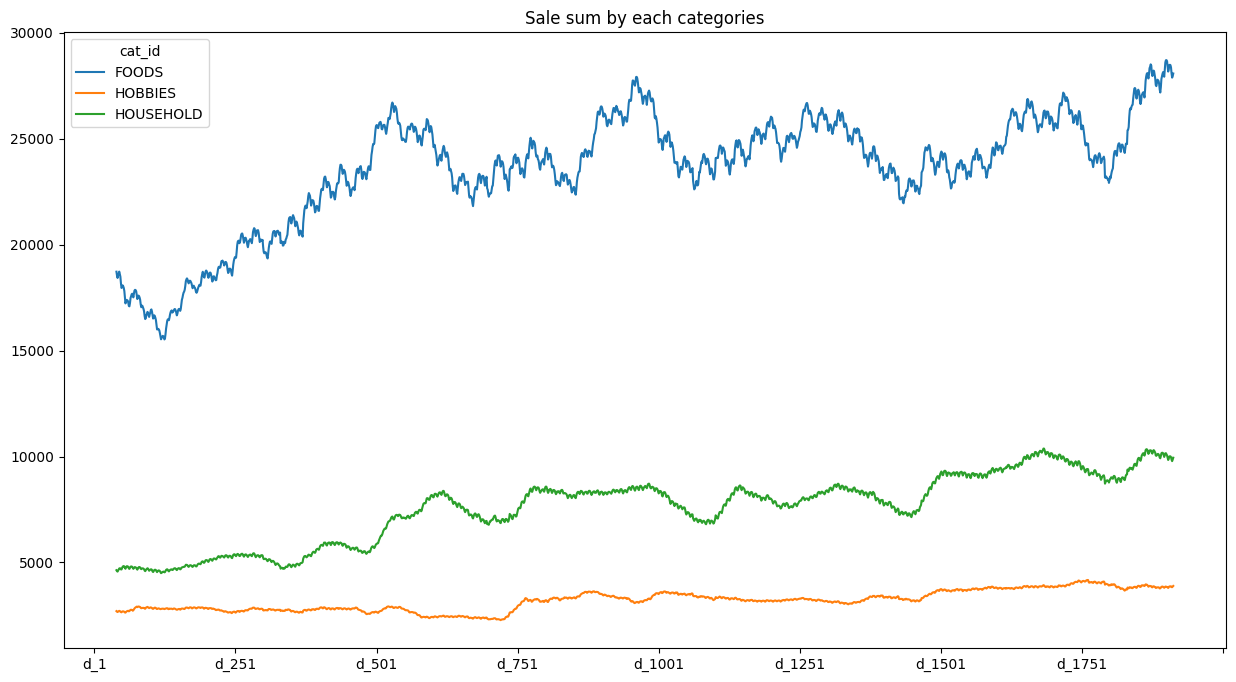

In [8]:
sales_sum_cat.T.rolling(40).mean().plot(figsize=(15,8), title='Sale sum by each categories')

/tmp/ipykernel_5787/687460395.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_sum_state = sales_raw.drop(columns=['id', 'item_id', 'dept_id']).groupby(['state_id']).sum().T


<AxesSubplot: title={'center': 'Sum sales by each state'}>

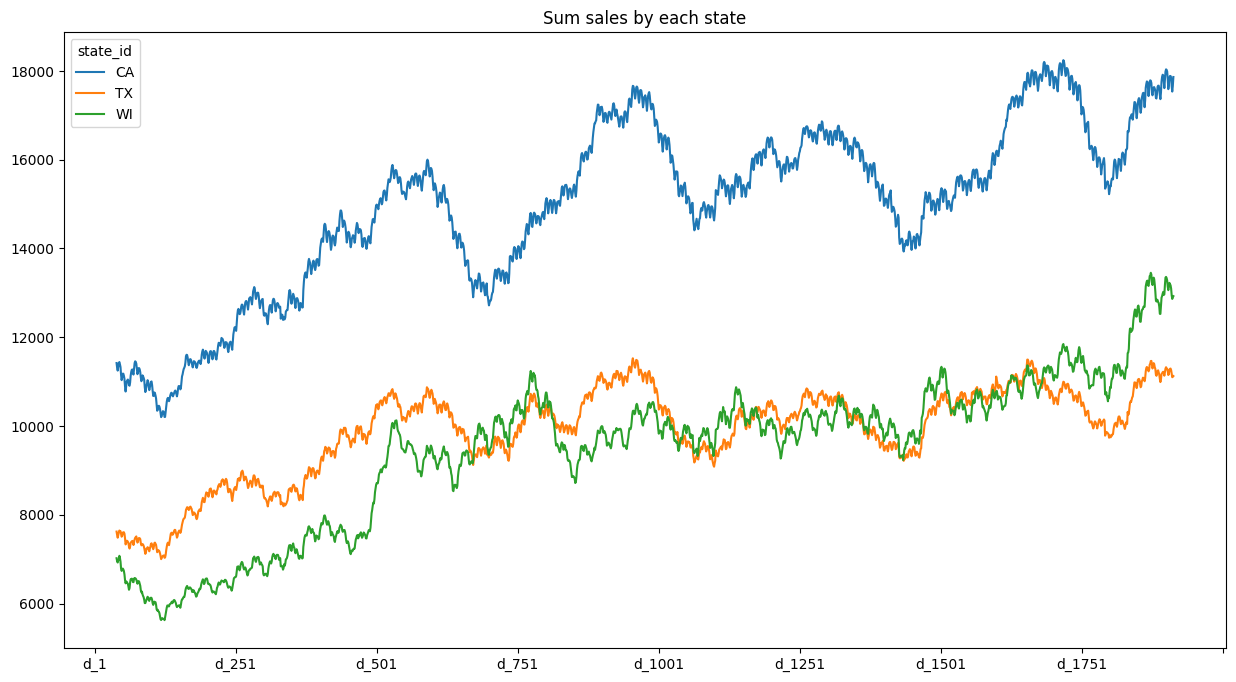

In [9]:
sales_sum_state = sales_raw.drop(columns=['id', 'item_id', 'dept_id']).groupby(['state_id']).sum().T
sales_sum_state.rolling(40).mean().plot(figsize=(15,8), title='Sum sales by each state')

/tmp/ipykernel_5787/1777668802.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_sum_store = sales_raw.drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['store_id']).sum().T


<AxesSubplot: title={'center': 'Sum sales by each store'}>

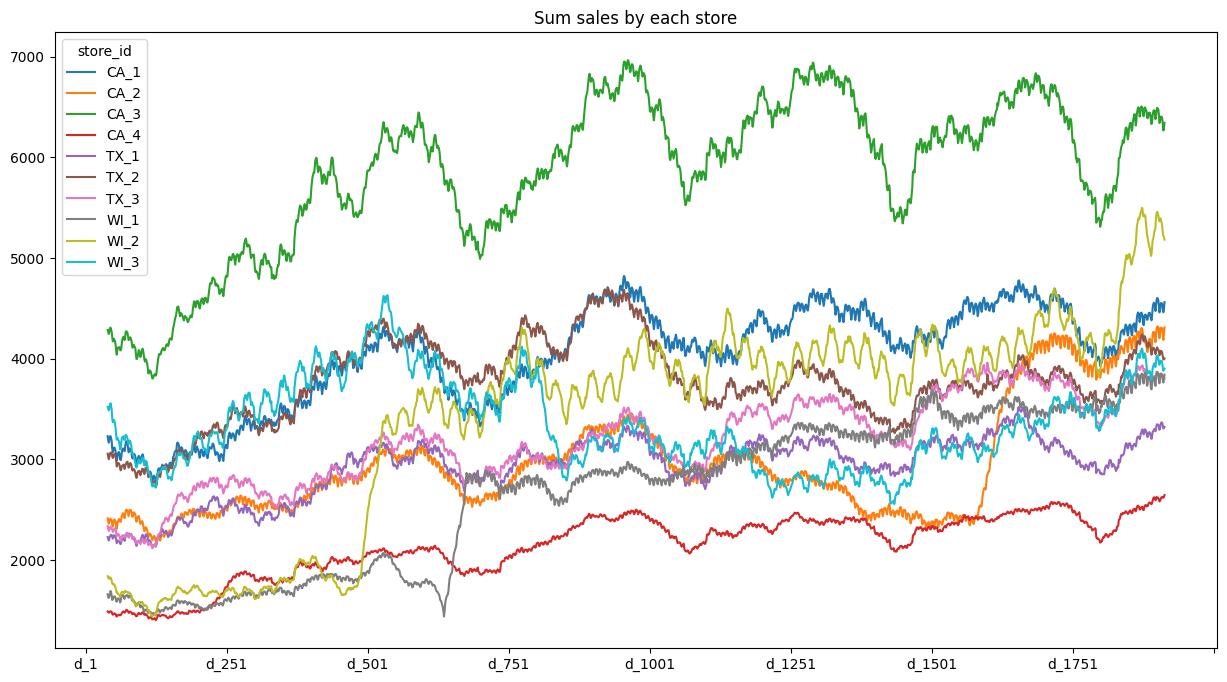

In [10]:
sales_sum_store = sales_raw.drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['store_id']).sum().T
sales_sum_store.rolling(40).mean().plot(figsize=(15,8), title='Sum sales by each store')

<AxesSubplot: >

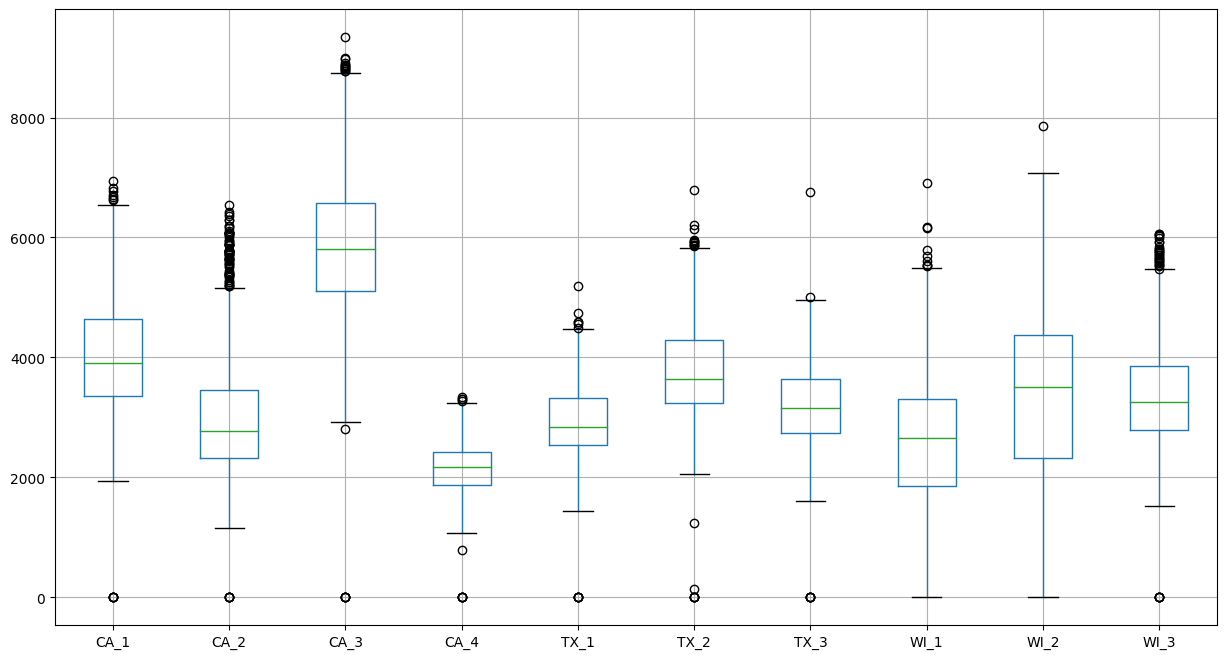

In [11]:
sales_sum_store.boxplot(figsize=(15,8))

From the box plot, we can see that some day have high sale above q3, so I want to see what happend with the day which have high amount

***
Check the zero sale date to find what happend with it.

In [12]:
sales_sum_zero_ca_1 = sales_sum_store[sales_sum_store['CA_1'] == 0]['CA_1'].reset_index().rename(columns={'index': 'd'}).merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_zero_ca_1.head()

,CA_1,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,,
d_331,0,2011-12-25,11148,Sunday,2,12,2011,Christmas,National,NaN,NaN,0,0,0
d_697,0,2012-12-25,11248,Tuesday,4,12,2012,Christmas,National,NaN,NaN,0,0,0
d_1062,0,2013-12-25,11348,Wednesday,5,12,2013,Christmas,National,NaN,NaN,0,0,0
d_1427,0,2014-12-25,11447,Thursday,6,12,2014,Christmas,National,NaN,NaN,0,0,0
d_1792,0,2015-12-25,11547,Friday,7,12,2015,Christmas,National,NaN,NaN,0,0,0


## By looking at the table we can see that the day with 0 sale is public holiday.

In [13]:
sales_sum_q4_ca_1 = sales_sum_store[sales_sum_store['CA_1'] > 6200]['CA_1'].reset_index().rename(columns={'index': 'd'}).merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_q4_ca_1.head()

,CA_1,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,,
d_736,6232,2013-02-02,11302,Saturday,1,2,2013,NaN,NaN,NaN,NaN,1,0,1
d_925,6308,2013-08-10,11329,Saturday,1,8,2013,NaN,NaN,NaN,NaN,1,0,0
d_926,6276,2013-08-11,11329,Sunday,2,8,2013,NaN,NaN,NaN,NaN,0,1,1
d_940,6948,2013-08-25,11331,Sunday,2,8,2013,NaN,NaN,NaN,NaN,0,0,0
d_946,6544,2013-08-31,11332,Saturday,1,8,2013,NaN,NaN,NaN,NaN,0,0,0


## Most of the high sale is come from saturday and sunday

***
# Effect of snap day

## California state

/tmp/ipykernel_5787/1825525601.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_sum_state = sales_raw[sales_raw['cat_id'] == 'FOODS'].drop(columns=['id', 'item_id', 'dept_id', 'cat_id']).groupby(['state_id']).sum().T


<AxesSubplot: xlabel='snap_CA'>

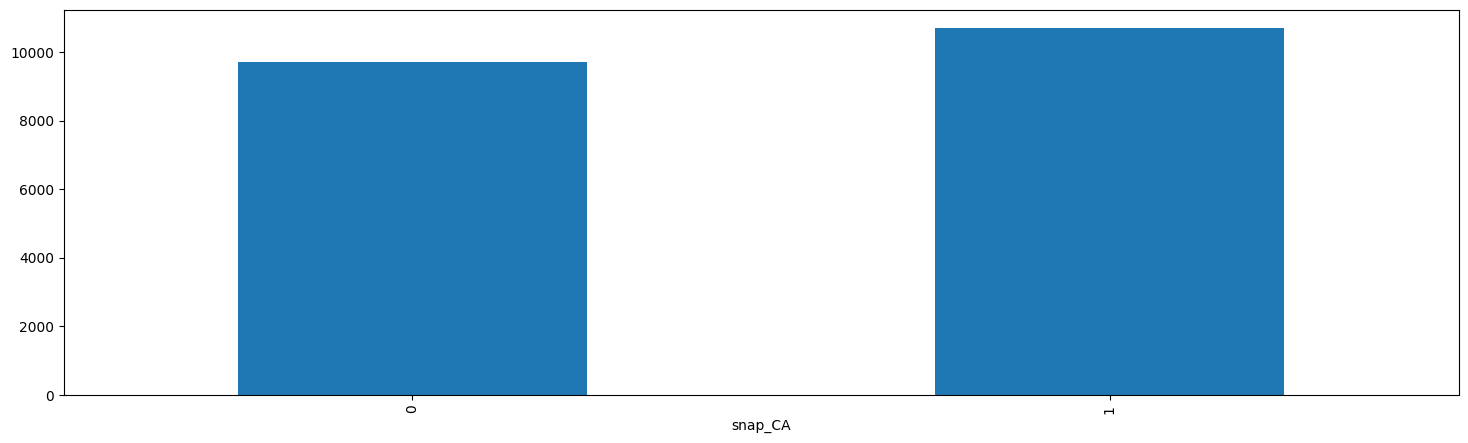

In [14]:
sales_sum_state = sales_raw[sales_raw['cat_id'] == 'FOODS'].drop(columns=['id', 'item_id', 'dept_id', 'cat_id']).groupby(['state_id']).sum().T
sales_sum_CA_food = sales_sum_state.drop(columns=['TX', 'WI']).reset_index().rename(columns={'index': 'd'}).merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_CA_food.reset_index().groupby(['snap_CA'])['CA'].mean().plot.bar(figsize=(18,5))

## Texas state

/tmp/ipykernel_5787/2132457059.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_sum_state = sales_raw[sales_raw['cat_id'] == 'FOODS'].drop(columns=['id', 'item_id', 'dept_id', 'cat_id']).groupby(['state_id']).sum().T


<AxesSubplot: xlabel='snap_TX'>

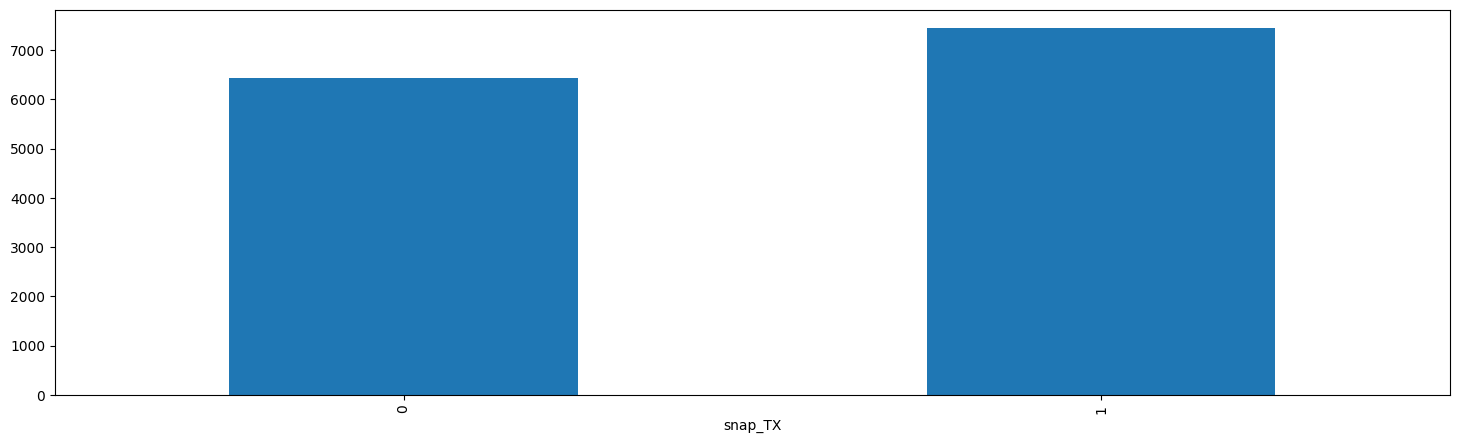

In [15]:
sales_sum_state = sales_raw[sales_raw['cat_id'] == 'FOODS'].drop(columns=['id', 'item_id', 'dept_id', 'cat_id']).groupby(['state_id']).sum().T
sales_sum_TX_food = sales_sum_state.drop(columns=['CA', 'WI']).reset_index().rename(columns={'index': 'd'}).merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_TX_food.reset_index().groupby(['snap_TX'])['TX'].mean().plot.bar(figsize=(18,5))

## Iowa state

/tmp/ipykernel_5787/2372172885.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_sum_state = sales_raw[sales_raw['cat_id'] == 'FOODS'].drop(columns=['id', 'item_id', 'dept_id', 'cat_id']).groupby(['state_id']).sum().T


<AxesSubplot: xlabel='snap_WI'>

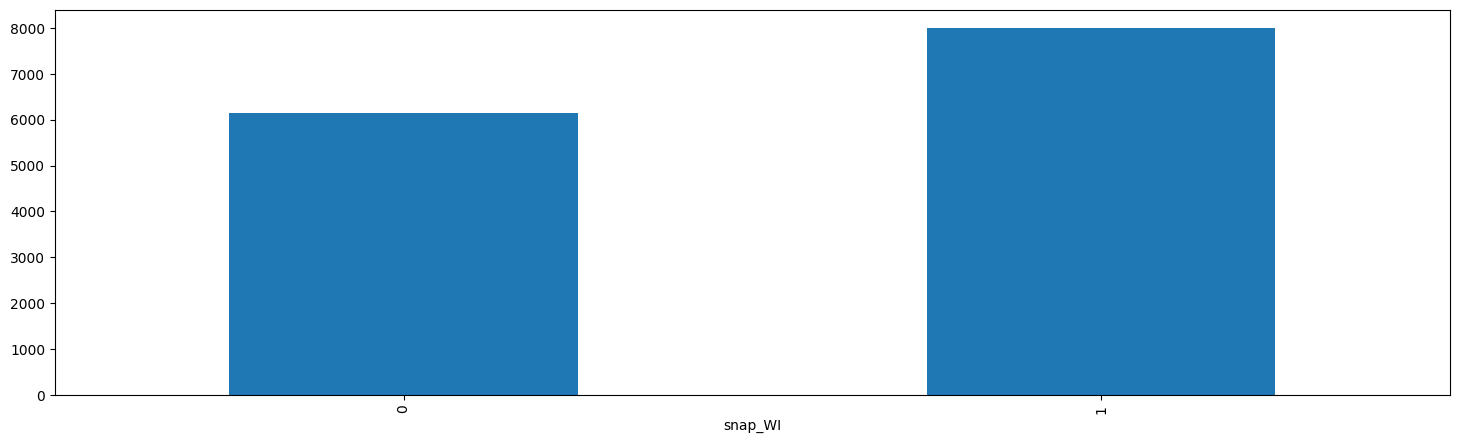

In [16]:
sales_sum_state = sales_raw[sales_raw['cat_id'] == 'FOODS'].drop(columns=['id', 'item_id', 'dept_id', 'cat_id']).groupby(['state_id']).sum().T
sales_sum_WI_food = sales_sum_state.drop(columns=['CA', 'TX']).reset_index().rename(columns={'index': 'd'}).merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_WI_food.reset_index().groupby(['snap_WI'])['WI'].mean().plot.bar(figsize=(18,5))

<h1>Category by week day average testing</h1>

In [17]:
sales_sum_cat = sales_raw.drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T
sales_sum_catT = sales_sum_cat.reset_index().rename(columns={'index': 'd'})

/tmp/ipykernel_5787/2517539663.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_sum_cat = sales_raw.drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T


Join with date

In [18]:
sales_sum_cat_joindate = sales_sum_catT.merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_cat_joindate.head()

,FOODS,HOBBIES,HOUSEHOLD,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,,,,
d_1,23178,3764,5689,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_2,22758,3357,5634,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_3,17174,2682,3927,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_4,18878,2669,3865,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
d_5,14603,1814,2729,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1


In [19]:
sales_cat_avg_weekday = sales_sum_cat_joindate[['FOODS', 'HOBBIES', 'HOUSEHOLD', 'weekday']].groupby(['weekday']).mean()
sales_cat_avg_weekday.head()

,FOODS,HOBBIES,HOUSEHOLD
weekday,,,
Friday,23264.146520,3323.827839,7638.010989
Monday,22735.402930,2980.336996,7137.227106
Saturday,28077.200730,3930.332117,9539.361314
Sunday,28346.890511,3564.182482,9218.948905
Thursday,20819.956044,2879.615385,6505.435897


<AxesSubplot: title={'center': 'Average sale amount by week day from every state'}, xlabel='weekday'>

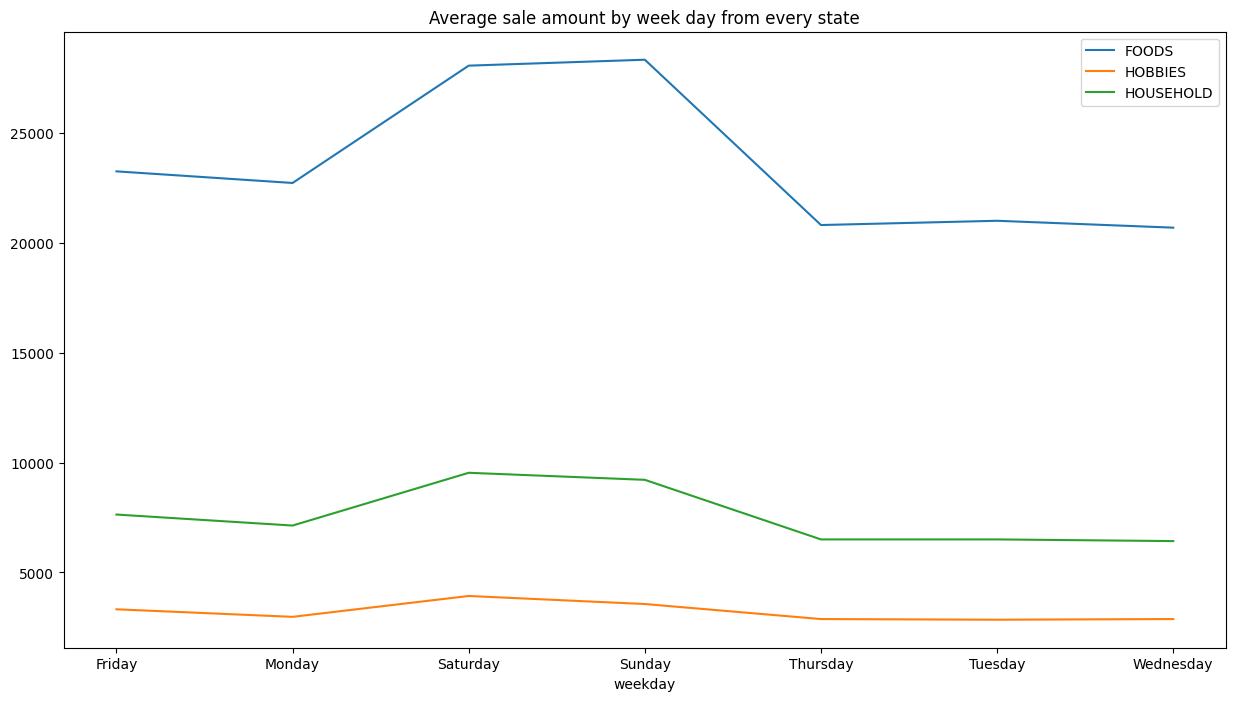

In [20]:
sales_cat_avg_weekday.plot(figsize=(15,8), title='Average sale amount by week day from every state')

/tmp/ipykernel_5787/4006351240.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_sum_cat_CA = sales_raw[sales_raw['state_id'] == 'CA'].drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T


<AxesSubplot: title={'center': 'Average sale amount by week day in California state'}, xlabel='weekday'>

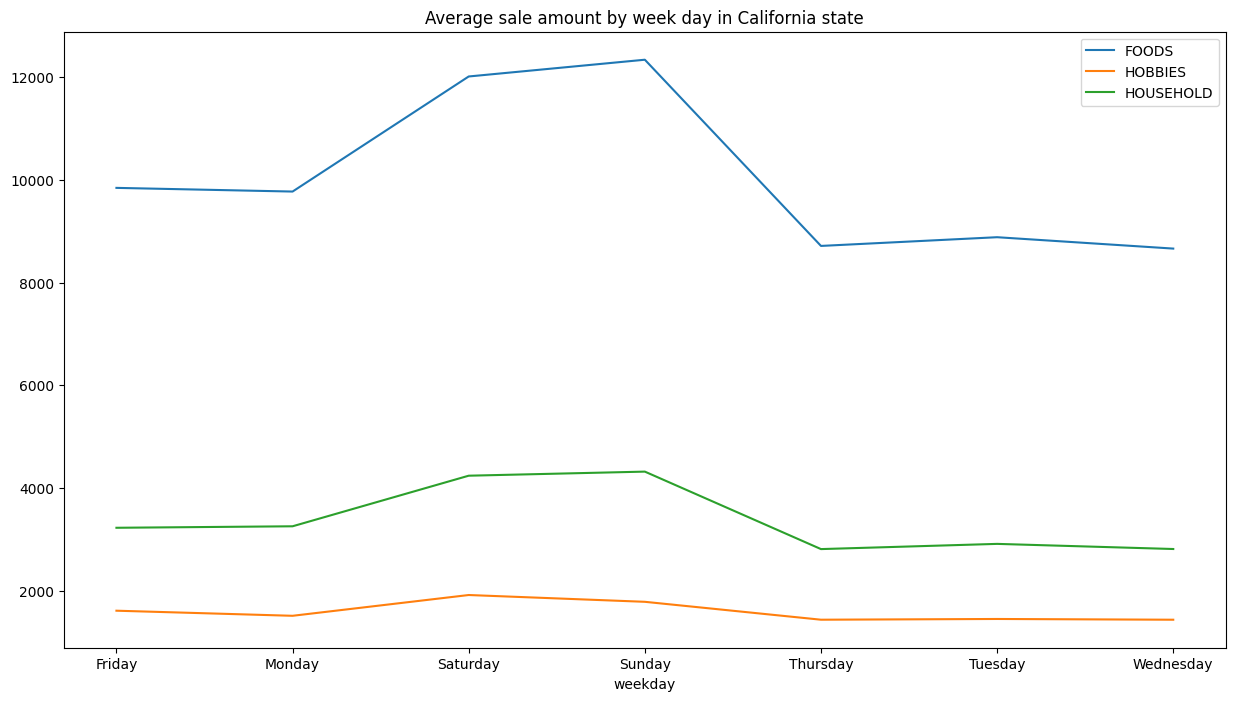

In [21]:
sales_sum_cat_CA = sales_raw[sales_raw['state_id'] == 'CA'].drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T
sales_sum_cat_CAT = sales_sum_cat_CA.reset_index().rename(columns={'index': 'd'})
sales_sum_cat_joindate_CA = sales_sum_cat_CAT.merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_cat_avg_weekday_CA = sales_sum_cat_joindate_CA[['FOODS', 'HOBBIES', 'HOUSEHOLD', 'weekday']].groupby(['weekday']).mean()
sales_cat_avg_weekday_CA.plot(figsize=(15,8), title='Average sale amount by week day in California state')

/tmp/ipykernel_5787/2437871160.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_sum_cat_TX = sales_raw[sales_raw['state_id'] == 'TX'].drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T


<AxesSubplot: title={'center': 'Average sale amount by week day in Texas state'}, xlabel='weekday'>

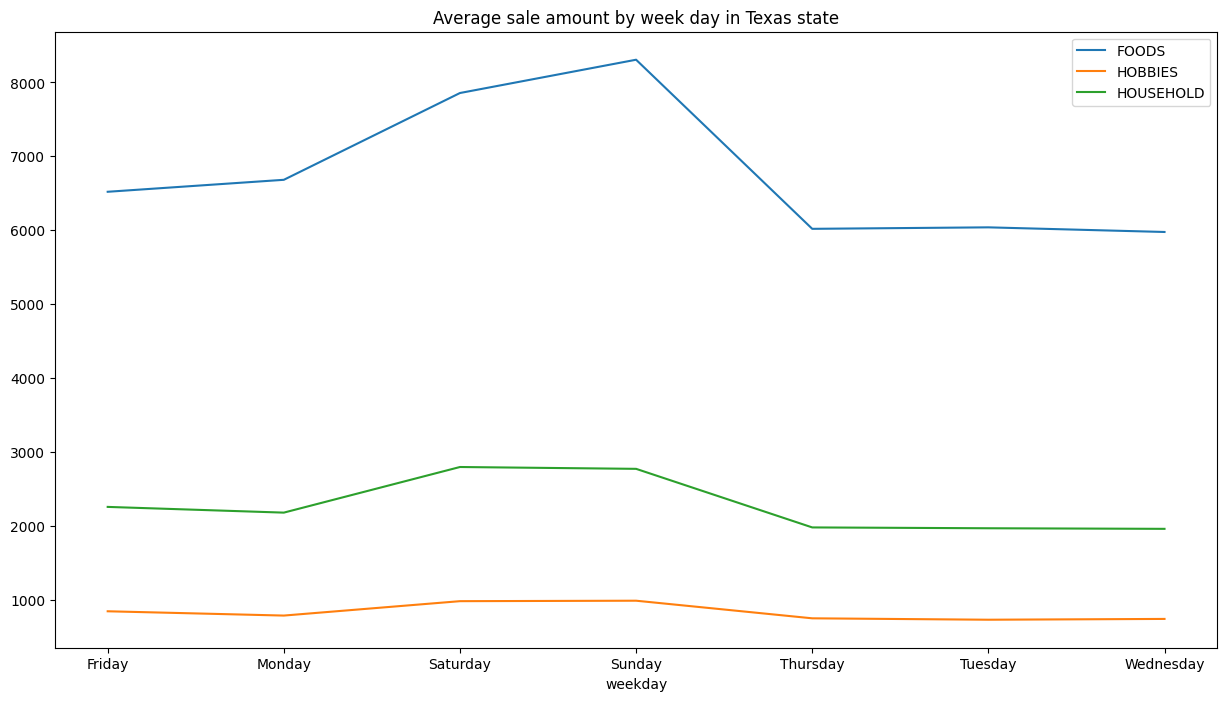

In [22]:
sales_sum_cat_TX = sales_raw[sales_raw['state_id'] == 'TX'].drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T
sales_sum_cat_TXT = sales_sum_cat_TX.reset_index().rename(columns={'index': 'd'})
sales_sum_cat_joindate_TX = sales_sum_cat_TXT.merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_cat_avg_weekday_TX = sales_sum_cat_joindate_TX[['FOODS', 'HOBBIES', 'HOUSEHOLD', 'weekday']].groupby(['weekday']).mean()
sales_cat_avg_weekday_TX.plot(figsize=(15,8), title='Average sale amount by week day in Texas state')

/tmp/ipykernel_5787/3458528197.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_sum_cat_WI = sales_raw[sales_raw['state_id'] == 'WI'].drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T


<AxesSubplot: title={'center': 'Average sale amount by week day in Iowa state'}, xlabel='weekday'>

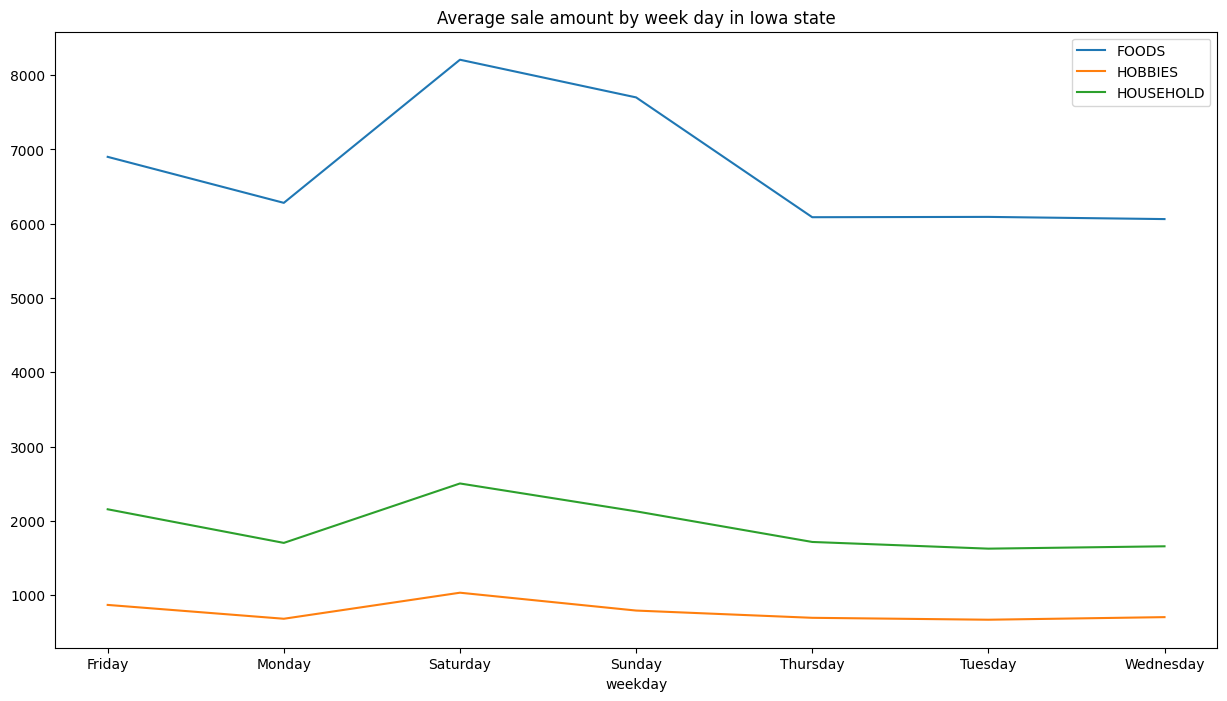

In [23]:
sales_sum_cat_WI = sales_raw[sales_raw['state_id'] == 'WI'].drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T
sales_sum_cat_WIT = sales_sum_cat_WI.reset_index().rename(columns={'index': 'd'})
sales_sum_cat_joindate_WI = sales_sum_cat_WIT.merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_cat_avg_weekday_WI = sales_sum_cat_joindate_WI[['FOODS', 'HOBBIES', 'HOUSEHOLD', 'weekday']].groupby(['weekday']).mean()
sales_cat_avg_weekday_WI.plot(figsize=(15,8), title='Average sale amount by week day in Iowa state')

***
#Summary
- We can see that the weekday have same effect on sale in every state. 
- The state have effect on sale amount. Thus, we must use state as another input for prediction model. 
- The weekday have a lot of effect on the sale amount. Thus, we should add week date to the model feature, so the model can understand and add some bias for each day.
***

***
# Feature selection
- state
- weekday
- category
- SNAP
- Price at date
***

In [24]:
import torch
import numpy as np
from tqdm import tqdm

In [25]:
sales_raw.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [26]:
cal = calendar_raw.loc[:, ['wday', 'weekday', 'snap_CA', 'snap_TX', 'snap_WI']]
cal.head()

,wday,weekday,snap_CA,snap_TX,snap_WI
0,1,Saturday,0,0,0
1,2,Sunday,0,0,0
2,3,Monday,0,0,0
3,4,Tuesday,1,1,0
4,5,Wednesday,1,0,1


In [27]:
def get_weekday_onehot(day):
    wday = cal.iloc[day].wday
    one_hot = [0,0,0,0,0,0,0]
    one_hot[wday - 1] = 1
    return one_hot

def get_snap(day, state):
    return cal.iloc[day]["snap_" + state]

In [28]:
ninputdate = 200
npredictdate = 28
skip = 50
max_date = 1913
dataset = []

for state in ['CA', 'TX', 'WI']:
    state_onehot = np.array([0, 0, 0])
    if state == 'CA': state_onehot[0] = 1
    if state == 'TX': state_onehot[1] = 1
    if state == 'WI': state_onehot[2] = 1
    for cat in ['FOODS', 'HOBBIES', 'HOUSEHOLD']:
        cat_onehot = np.array([0, 0, 0])
        if cat == 'FOODS': cat_onehot[0] = 1
        if cat == 'HOBBIES': cat_onehot[1] = 1
        if cat == 'HOUSEHOLD': cat_onehot[2] = 1
        sales = sales_raw[(sales_raw['state_id'] == state) & (sales_raw['cat_id'] == cat)].drop(columns=['id', 'item_id', 'dept_id', 'state_id', 'cat_id', 'store_id'])
        for row_idx in tqdm(range(len(sales))):
            for col_idx in range(0, max_date-ninputdate-npredictdate, skip):
                target = sales.iloc[row_idx, col_idx+ninputdate : col_idx+ninputdate+npredictdate].values.tolist()
                data = []
                for date, sales_per_date in enumerate(sales.iloc[row_idx, col_idx : col_idx+ninputdate].values.tolist()):
                    one_seq = [sales_per_date, *get_weekday_onehot(date), *state_onehot, *cat_onehot, get_snap(date, state)]
                    data.append(one_seq)
                dataset.append((data, target))


  2%|▏         | 93/5748 [01:50<1:51:31,  1.18s/it]


KeyboardInterrupt: 

In [ ]:
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [ ]:
model = Model()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
if (torch.cuda.is_available()):
    model.cuda()
    print("cuda")

In [ ]:
no_epochs = 10
train_loss = list()
val_loss = list()
best_val_loss = 1
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

In [ ]:
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)